In [ ]:
import matplotlib.pyplot as plt          #Первая Мини версия
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

# Загружаем модель напрямую из Hugging Face
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",  # Можно заменить на "amazon/chronos-t5-base" или "amazon/chronos-t5-large"
    device_map="cuda" if torch.cuda.is_available() else "cpu",
    torch_dtype=torch.bfloat16,
)

# Загружаем данные
data = pd.read_csv('C:/Users/bondarenkovv/Desktop/Python/NeuralProphet/Magazin/Sales.csv', sep=';', low_memory=False)
data['Дата'] = pd.to_datetime(data['Дата'], dayfirst=True)
data = data.rename(columns={'Дата': 'ds', 'Номер Магазина': 'store', '(Сутки).(Сумма продаж в фактических ценах реализации(валюта))': 'y'})
data['y'] = data['y'].astype(str).str.replace(',', '.').astype(float)
data = data.drop_duplicates(subset=['store', 'ds']).dropna()
data = data.sort_values(by=['store', 'ds']).reset_index(drop=True)

# Заполняем пропущенные даты
date_range = pd.date_range(start=data['ds'].min(), end=data['ds'].max(), freq='D')
all_stores = data['store'].unique()
full_index = pd.MultiIndex.from_product([all_stores, date_range], names=['store', 'ds'])
data = data.set_index(['store', 'ds']).reindex(full_index).fillna(0).reset_index()

# Параметры прогнозирования
prediction_length = 40  # Прогноз на 30 дней

# Список для хранения прогнозов
forecasts = []

# Прогноз для каждого магазина
for store in all_stores:
    # Выбираем данные для текущего магазина
    store_data = data[data['store'] == store]['y'].values
    context = torch.tensor(store_data, dtype=torch.float32)  # Контекст — исторические данные
    
    # Генерируем прогноз
    forecast = pipeline.predict(context, prediction_length)  # shape: [1, num_samples, prediction_length]
    forecasts.append(forecast[0].numpy())  # Сохраняем прогноз как numpy массив

# Преобразуем прогнозы в DataFrame
forecast_df = pd.DataFrame({
    'store': all_stores,
    'forecast': [np.median(f, axis=0) for f in forecasts]  # Берем медиану по сэмплам
})

# Разворачиваем прогноз по дням
forecast_days = pd.date_range(start=data['ds'].max() + pd.Timedelta(days=1), periods=prediction_length, freq='D')
forecast_expanded = forecast_df.explode('forecast').reset_index(drop=True)
forecast_expanded['ds'] = forecast_days.tolist() * len(all_stores)

# Сохраняем результат
forecast_expanded.to_excel('Chronos_T5_Forecast.xlsx', index=False)
print("Прогноз успешно сохранен!")

In [2]:
import matplotlib.pyplot as plt  # ТОП прогноз + праздничные дни
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

# Загружаем модель напрямую из Hugging Face
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cuda" if torch.cuda.is_available() else "cpu",
    torch_dtype=torch.bfloat16,
)

# Загружаем данные
data = pd.read_csv('C:/Users/bondarenkovv/Desktop/Python/NeuralProphet/Magazin/Sales.csv', sep=';', low_memory=False)
data['Дата'] = pd.to_datetime(data['Дата'], dayfirst=True)
data = data.rename(columns={'Дата': 'ds', 'Номер Магазина': 'store', '(Сутки).(Сумма продаж в фактических ценах реализации(валюта))': 'y'})
data['y'] = data['y'].astype(str).str.replace(',', '.').astype(float)
data = data.drop_duplicates(subset=['store', 'ds']).dropna()
data = data.sort_values(by=['store', 'ds']).reset_index(drop=True)

# Заполняем пропущенные даты
date_range = pd.date_range(start=data['ds'].min(), end=data['ds'].max(), freq='D')
all_stores = data['store'].unique()
full_index = pd.MultiIndex.from_product([all_stores, date_range], names=['store', 'ds'])
data = data.set_index(['store', 'ds']).reindex(full_index).fillna(0).reset_index()

# Параметры прогнозирования
prediction_length = 40  # Прогноз на 40 дней

# Список для хранения прогнозов
forecasts = []

# Прогноз для каждого магазина
for store in all_stores:
    # Выбираем данные для текущего магазина
    store_data = data[data['store'] == store]['y'].values
    context = torch.tensor(store_data, dtype=torch.float32)  # Контекст — исторические данные
    
    # Генерируем прогноз
    forecast = pipeline.predict(context, prediction_length)  # shape: [1, num_samples, prediction_length]
    forecasts.append(forecast[0].numpy())  # Сохраняем прогноз как numpy массив

# Преобразуем прогнозы в DataFrame
forecast_df = pd.DataFrame({
    'store': all_stores,
    'forecast': [np.median(f, axis=0) for f in forecasts]  # Берем медиану по сэмплам
})

# Разворачиваем прогноз по дням
forecast_days = pd.date_range(start=data['ds'].max() + pd.Timedelta(days=1), periods=prediction_length, freq='D')
forecast_expanded = forecast_df.explode('forecast').reset_index(drop=True)
forecast_expanded['ds'] = forecast_days.tolist() * len(all_stores)

# Добавляем предпраздничные дни вручную
pre_holiday_dates = pd.to_datetime([
    '2025-02-22', '2025-03-07', '2025-05-08', '2025-06-11', '2025-04-20', '2025-05-02', '2025-05-03',
    '2024-12-28', '2024-12-29', '2024-12-30', '2024-12-31', '2025-12-28', '2025-12-29', '2025-12-30', '2025-12-31'
])
forecast_expanded['is_pre_holiday'] = forecast_expanded['ds'].isin(pre_holiday_dates).astype(int)

# Корректируем прогноз только для предпраздничных дней
forecast_expanded['forecast'] = forecast_expanded['forecast'] * (1 + 0.15 * forecast_expanded['is_pre_holiday'])

# Сохраняем результат
forecast_expanded.to_excel('Chronos_T5_Forecast_with_pre_holidays.xlsx', index=False)
print("Прогноз успешно сохранен!")

Прогноз успешно сохранен!


C:\Users\bondarenkovv\AppData\Local\Temp\ipykernel_9524\822021523.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


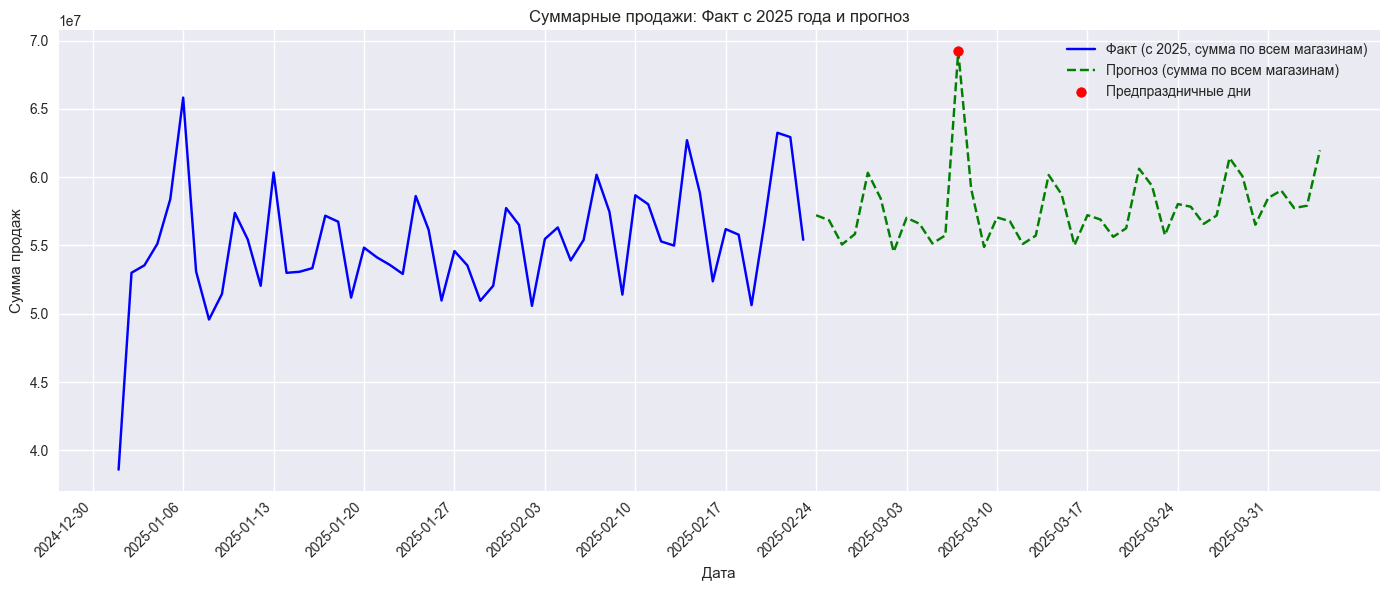

График с суммарными фактическими данными с 2025 года и прогнозом с шагом 7 дней построен и сохранен!


In [9]:
# Блок визуализации: Суммарный факт с начала 2025 года + суммарный прогноз по дням с шагом 7 дней с 30 декабря 2024
import matplotlib.pyplot as plt
import pandas as pd

# Настройки для графиков
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (14, 6)  # Увеличим ширину для лучшей видимости

# Фильтруем фактические данные с начала 2025 года и считаем сумму по всем магазинам
start_date = pd.to_datetime('2025-01-01')
fact_2025 = data[data['ds'] >= start_date].copy()
fact_total = fact_2025.groupby('ds')['y'].sum().reset_index()

# Считаем суммарный прогноз по всем магазинам
forecast_total = forecast_expanded.groupby('ds')['forecast'].sum().reset_index()
forecast_total['is_pre_holiday'] = forecast_total['ds'].isin(pre_holiday_dates).astype(int)

# Определяем пользовательские метки с шагом 7 дней, начиная с 30 декабря 2024
start_xticks = pd.to_datetime('2024-12-30')
end_date = forecast_total['ds'].max()  # Последняя дата прогноза
xticks = pd.date_range(start=start_xticks, end=end_date, freq='7D')

# Построение графика
plt.figure()
# Факт
plt.plot(fact_total['ds'], fact_total['y'], label='Факт (с 2025, сумма по всем магазинам)', color='blue')
# Прогноз
plt.plot(forecast_total['ds'], forecast_total['forecast'], label='Прогноз (сумма по всем магазинам)', color='green', linestyle='--')
# Отмечаем предпраздничные дни на прогнозе
pre_holiday_forecast = forecast_total[forecast_total['is_pre_holiday'] == 1]
plt.scatter(pre_holiday_forecast['ds'], pre_holiday_forecast['forecast'], 
            color='red', label='Предпраздничные дни', zorder=5, s=50)

plt.title('Суммарные продажи: Факт с 2025 года и прогноз')
plt.xlabel('Дата')
plt.ylabel('Сумма продаж')
plt.legend()
plt.grid(True)

# Устанавливаем метки с шагом 7 дней
plt.xticks(xticks, rotation=45, ha='right')  # Метки каждые 7 дней с 30 декабря 2024
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))  # Формат даты
plt.tight_layout()
plt.savefig('Total_fact_2025_forecast_7days_from_2024-12-30.png')  # Сохранение графика
plt.show()

print("График с суммарными фактическими данными с 2025 года и прогнозом с шагом 7 дней построен и сохранен!")